### Load data ###

In [2]:
import pickle

with open('NBA_temporal_dataset.pkl', 'rb') as file:
    temporal_data_dict = pickle.load(file)

X_primary = temporal_data_dict['X_primary']
X_opposing = temporal_data_dict['X_opposing'] 
y = temporal_data_dict['y']

print(X_primary.shape)
print(X_opposing.shape)
print(y.shape)

(83178, 5, 42)
(83178, 5, 42)
(83178, 1)


### Reshape data so that each sample is 2D array ###

In [3]:
import numpy as np

X_primary = X_primary.reshape(X_primary.shape[0], -1)
X_opposing = X_opposing.reshape(X_opposing.shape[0], -1)

X = np.concatenate((X_primary, X_opposing), axis=1)
print(X.shape)
print(y.shape)

(83178, 420)
(83178, 1)


In [4]:
import torch

X_torch = torch.from_numpy(X).float()
y_torch = torch.from_numpy(y).float()

In [5]:
from torch.utils.data import Dataset, DataLoader

class NBADataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        return self.X_data[idx], self.y_data[idx]

In [6]:
from torch.utils.data import random_split

dataset = NBADataset(X_torch, y_torch)

train_size = int(0.75 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 1024

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Create FFN module ##

In [7]:
# Team FFN module
import torch
import torch.nn as nn

class TeamFFN(nn.Module):
    def __init__(self, input_size=210):
        super(TeamFFN, self).__init__()
        self.subnet = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )

    def forward(self, x):
        return self.subnet(x)



In [8]:
class DualTeamFFN(nn.Module):
    def __init__(self, input_team_size=210):
        super(DualTeamFFN, self).__init__()
        self.primary_net = TeamFFN(input_size=input_team_size)
        self.opposing_net = TeamFFN(input_size=input_team_size)

        self.final_layers = nn.Sequential(
            nn.Linear(64 * 2, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)  # binary classification
        )

    def forward(self, x):
        # Split the 420-dim input into two 210-dim parts
        x_primary = x[:, :210]
        x_opposing = x[:, 210:]

        h_primary = self.primary_net(x_primary)
        h_opposing = self.opposing_net(x_opposing)

        combined = torch.cat([h_primary, h_opposing], dim=1)
        out = self.final_layers(combined)
        return out

In [9]:
# Function to train and test model 
import time


def AccuracyAndLossOverEpoch(model, train_loader, test_loader, optimizer, criterion, device, epochs):
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    time_to_train_per_epoch_list = []

    model.to(device)

    for epoch in range(epochs):
        # Set current epoch train loss, train accuracy and test accuracy to 0.0
        train_loss = 0.0
        train_acc = 0.0
        test_acc = 0.0
        time_per_epoch = 0.0
        # Put model in training mode
        model.train()
        start_time = time.time()
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            # Get loss on current batch
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            # Accumulate train loss in epoch
            train_loss += loss.item()
        # Add train loss to train_losses, in order to track
        # print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}")
        train_losses.append(train_loss)
        end_time = time.time()
        
        # Calculate time per epoch and accumulate
        time_per_epoch = end_time - start_time
        time_to_train_per_epoch_list.append(time_per_epoch)
        
        # Put model in evaluation mode
        model.eval()
        correct = 0.0
        total = 0.0
        with torch.no_grad():
            # Iterate over train dataset, in order to get accuracy for model at current epoch
            for X_batch, y_batch in train_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                y_pred = model(X_batch)
                y_pred = nn.Sigmoid()(y_pred)
                y_pred = (y_pred >= 0.5).float().round()
                correct += (y_pred == y_batch).sum().item()
                total += len(y_batch)
        # Add train accuracy to train_accuracies
        train_acc = correct / total
        print(f"Epoch {epoch+1}, Training Accuracy: {train_acc}")
        train_accuracies.append(train_acc)

        # Put model in evaluation mode
        model.eval()
        correct = 0.0
        total = 0.0
        with torch.no_grad():
            # Iterate over test dataset, in order to get accuracy for model at current epoch
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                y_pred = model(X_batch)
                y_pred = nn.Sigmoid()(y_pred)
                y_pred = (y_pred >= 0.5).float()
                # print(y_pred)
                # print(y_batch)
                correct += (y_pred == y_batch).sum().item()
                total += len(y_batch)
        # Add test accuracy to test_accuracies
        test_acc = correct / total
        print(f"Epoch {epoch+1}, Test Accuracy: {test_acc}")
        test_accuracies.append(test_acc)

    return train_losses, train_accuracies, test_accuracies, time_to_train_per_epoch_list

In [10]:
# initialize model, optimizer and loss function

model = DualTeamFFN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [11]:
# Train and test model 
train_losses, train_accuracies, test_accuracies, time_to_train_per_epoch_list = AccuracyAndLossOverEpoch(model, train_loader, test_loader, optimizer, criterion, device, epochs = 100)

Epoch 1, Training Accuracy: 0.5774650145071574
Epoch 1, Test Accuracy: 0.5650396729983169
Epoch 2, Training Accuracy: 0.5997467258708302
Epoch 2, Test Accuracy: 0.5841788891560471
Epoch 3, Training Accuracy: 0.6093006107433114
Epoch 3, Test Accuracy: 0.5931233469584034
Epoch 4, Training Accuracy: 0.6120417421412885
Epoch 4, Test Accuracy: 0.5953354171675883
Epoch 5, Training Accuracy: 0.6158729140951862
Epoch 5, Test Accuracy: 0.598557345515749
Epoch 6, Training Accuracy: 0.6182934453296571
Epoch 6, Test Accuracy: 0.6002885308968502
Epoch 7, Training Accuracy: 0.6189987656893705
Epoch 7, Test Accuracy: 0.5988458764125992
Epoch 8, Training Accuracy: 0.619239215812
Epoch 8, Test Accuracy: 0.5991344073094493
Epoch 9, Training Accuracy: 0.623503197986631
Epoch 9, Test Accuracy: 0.6012503005530175
Epoch 10, Training Accuracy: 0.6224612474552362
Epoch 10, Test Accuracy: 0.6009617696561673
Epoch 11, Training Accuracy: 0.6242085183463444
Epoch 11, Test Accuracy: 0.6041836980043279
Epoch 12, Tr

Total time to train model: 86.28984355926514
Number of epochs:  100
Average time per epoch:  0.8628984355926513


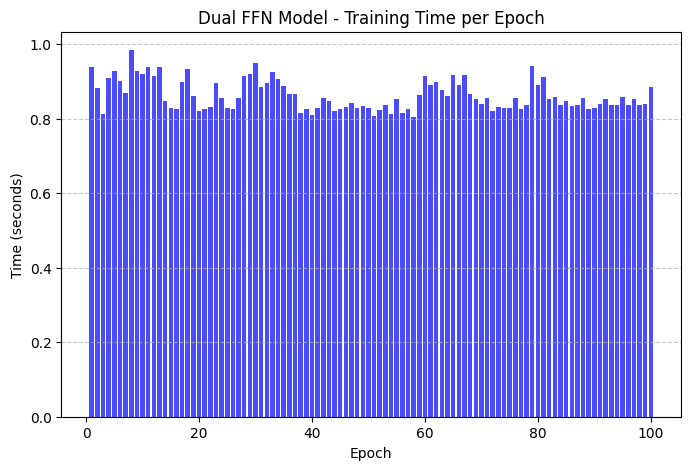

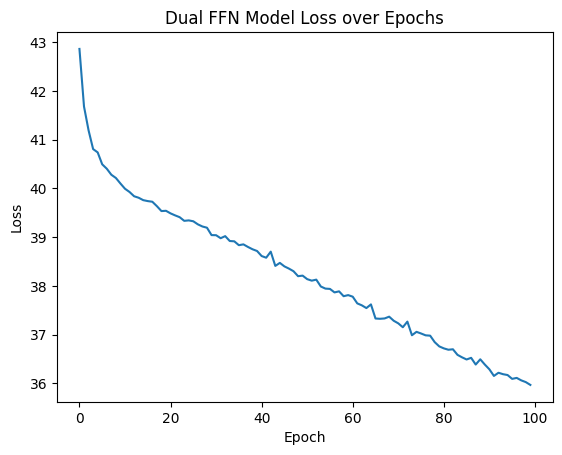

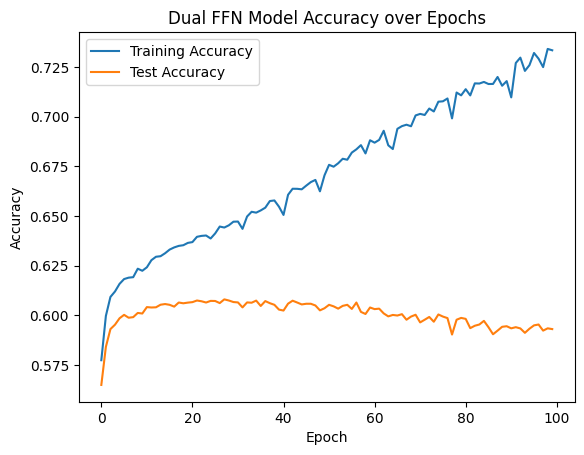

In [12]:
import matplotlib.pyplot as plt

def plot_time_loss_train_test_accuracies(train_accuracies, test_accuracies, time_to_train_per_epoch_list, model_name):

    print(f"Total time to train model: {sum(time_to_train_per_epoch_list)}")

    print("Number of epochs: ", len(time_to_train_per_epoch_list))

    print("Average time per epoch: ", sum(time_to_train_per_epoch_list) / len(time_to_train_per_epoch_list))

    epochs = list(range(1, len(time_to_train_per_epoch_list) + 1))  # Epoch numbers

    plt.figure(figsize=(8, 5))
    plt.bar(epochs, time_to_train_per_epoch_list, color='blue', alpha=0.7)
    plt.xlabel("Epoch")
    plt.ylabel("Time (seconds)")
    plt.title(f"{model_name} - Training Time per Epoch")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    plt.plot(train_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(model_name + " Loss over Epochs")
    plt.show()

    plt.plot(train_accuracies, label="Training Accuracy")
    plt.plot(test_accuracies, label="Test Accuracy")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(model_name + " Accuracy over Epochs")
    plt.show()


plot_time_loss_train_test_accuracies(train_accuracies, test_accuracies, time_to_train_per_epoch_list, "Dual FFN Model")

In [25]:
# Function for evaluating model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_ffn_classifier(model, test_dataset, model_name="FFN", batch_size=512):
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch).squeeze()
            probs = torch.sigmoid(logits)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend((probs >= 0.5).int().cpu().numpy())
            all_labels.extend(y_batch.int().cpu().numpy())

    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)
    cm = confusion_matrix(all_labels, all_preds)

    # Print metrics
    print(f"\nEvaluation for {model_name}")
    print(f"Accuracy     : {acc:.4f}")
    print(f"Precision    : {prec:.4f}")
    print(f"Recall       : {rec:.4f}")
    print(f"F1 Score     : {f1:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:\n", classification_report(all_labels, all_preds))

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def plot_prediction_distribution_ffn(model, test_dataset, model_name="FFN", batch_size=512):
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            logits = model(X_batch).squeeze()
            probs = torch.sigmoid(logits)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels).ravel()

    true_win_probs = all_probs[all_labels == 1]
    true_loss_probs = all_probs[all_labels == 0]

    plt.figure(figsize=(8, 5))
    sns.histplot(true_win_probs, color="green", label="True Wins", kde=True, stat="density", bins=30)
    sns.histplot(true_loss_probs, color="red", label="True Losses", kde=True, stat="density", bins=30)

    plt.title(f"{model_name} – Probability Distribution of Predicted Wins")
    plt.xlabel("Predicted Probability of Win")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_roc_curve_ffn(model, test_dataset, model_name="FFN", batch_size=512):
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            logits = model(X_batch).squeeze()
            probs = torch.sigmoid(logits)  # convert logits to probabilities
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve – {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("roc_curve_dualffn.png", dpi=300)
    plt.show()
    




Evaluation for Dual FFN
Accuracy     : 0.5931
Precision    : 0.5852
Recall       : 0.6307
F1 Score     : 0.6071
ROC-AUC Score: 0.6315

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.56      0.58     10430
           1       0.59      0.63      0.61     10365

    accuracy                           0.59     20795
   macro avg       0.59      0.59      0.59     20795
weighted avg       0.59      0.59      0.59     20795



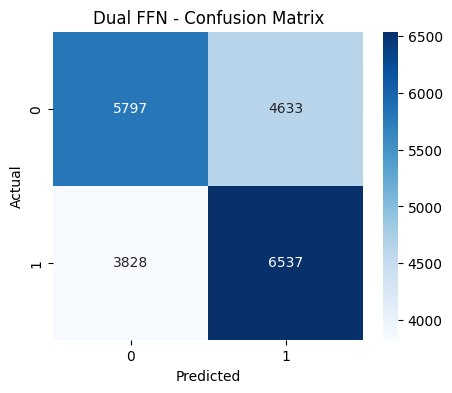

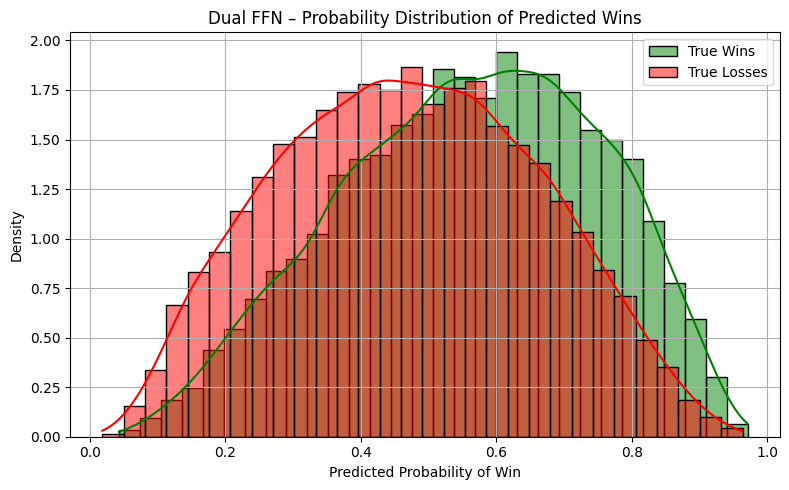

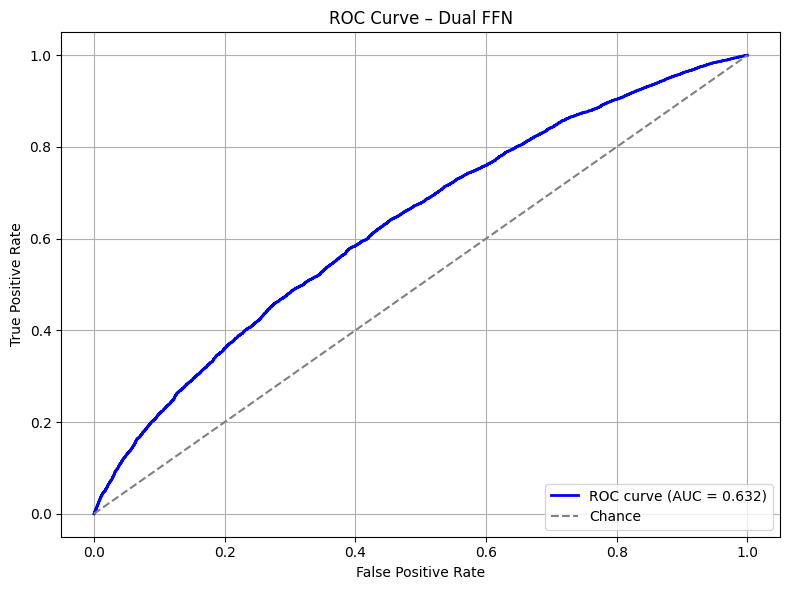

In [26]:
evaluate_ffn_classifier(model, test_dataset, model_name="Dual FFN")
plot_prediction_distribution_ffn(model, test_dataset, model_name="Dual FFN")
plot_roc_curve_ffn(model, test_dataset, model_name="Dual FFN")

### Save the model ###

In [15]:
import os

# Create the directory if it doesn't exist
os.makedirs('models', exist_ok=True)

path = os.path.join('.', 'models', 'dual_ffn_model.pth')

# Save the model's state_dict
torch.save(model.state_dict(), path)

### Load model ###

In [16]:
import os

# Load the model's state_dict

model = DualTeamFFN()
path = os.path.join('.', 'models', 'dual_ffn_model.pth')
model.load_state_dict(torch.load(path))
model.eval()

C:\Users\Alex1\AppData\Local\Temp\ipykernel_87608\3374443510.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


DualTeamFFN(
  (primary_net): TeamFFN(
    (subnet): Sequential(
      (0): Linear(in_features=210, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.3, inplace=False)
      (4): Linear(in_features=128, out_features=64, bias=True)
      (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
    )
  )
  (opposing_net): TeamFFN(
    (subnet): Sequential(
      (0): Linear(in_features=210, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.3, inplace=False)
      (4): Linear(in_features=128, out_features=64, bias=True)
      (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
    )
  )
  (final_layers): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=Tru

In [17]:
print(train_accuracies)
print(test_accuracies)
print(time_to_train_per_epoch_list)

[0.5774650145071574, 0.5997467258708302, 0.6093006107433114, 0.6120417421412885, 0.6158729140951862, 0.6182934453296571, 0.6189987656893705, 0.619239215812, 0.623503197986631, 0.6224612474552362, 0.6242085183463444, 0.6277992401776125, 0.62951445105237, 0.6297869611913502, 0.6312777519516535, 0.6331212028918135, 0.6342112434477342, 0.6349806838401487, 0.6353173140118301, 0.6364875046086274, 0.6368882548130099, 0.6395492361701105, 0.6400141064071942, 0.6402064665052979, 0.6386996457368194, 0.641264447044868, 0.6447108988025584, 0.6442139685491239, 0.6453360691213953, 0.6471474600452046, 0.6472276100860811, 0.6435407082057611, 0.6497603513777792, 0.6521327925877243, 0.651699982366991, 0.6528220829392622, 0.6542006636423384, 0.6575349053428017, 0.6578394754981325, 0.6547136239039482, 0.6505458217783691, 0.6606928169533366, 0.6637224884984692, 0.6636904284821186, 0.6634339483513136, 0.6653094593078243, 0.6670727602071077, 0.6681628007630284, 0.6624240578362695, 0.6704711219402721, 0.675761

In [18]:
import csv

def save_training_stats_to_csv(filename, train_acc, test_acc, train_loss, time_per_epoch):
    with open(filename, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Epoch", "Train Accuracy", "Test Accuracy", "Train Loss", "Time per Epoch (s)"])

        for epoch in range(len(train_acc)):
            writer.writerow([
                epoch + 1,
                train_acc[epoch],
                test_acc[epoch],
                train_loss[epoch],
                time_per_epoch[epoch]
            ])


save_training_stats_to_csv(
    os.path.join('.', 'training_data' ,'dual_ffn.csv'),
    train_accuracies,
    test_accuracies,
    train_losses,
    time_to_train_per_epoch_list
)